In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math as m
import time 
from numpy.lib.format import open_memmap

## The Thomas Algorithm
The thomas algorithm is a more computationally efficient way to solve for the unknowns as compared to matrix inversion (works via LU decomposition).

In [2]:
# Define the tridiagonal matrix solver algorithm for BLACK-SCHOLES EQUATION FORMAT
'''
For Tx = d
Inputs:
    - a = lower triangular vector
    - b = diagonal vector
    - c = upper diagonal vector
    - d = -aV_{i-1}^n + (1 + b)V_i^n - cV_{i+1}^n = constant term of knowns for share prices (i-1, i, i+1) at time n
Output:
    - unew = updated v values over space for time n+1
'''
def TDMA(a,b,c,d):
    n = len(d)
    e = np.zeros(n-1)
    f = np.zeros(n)
    V = np.zeros(n)
    
    e[0] = c[0]/b[0]
    f[0] = d[0]/b[0]
    for i in range(1,n-1):
        e[i] = c[i]/(b[i] - a[i]*e[i-1])
    for i in range(1,n):
        f[i] = (d[i] - a[i]*f[i-1])/(b[i] - a[i]*e[i-1])
    
    V[n-1] = f[n-1]
    for i in range(n-1,0,-1):
        V[i-1] = f[i-1] - e[i-1]*V[i]
    return V

## Call Option  Parameters

In [3]:
### // CALL OPTION PARAMETERS /// ###
sig = 0.15 # volatility (std deviation of log returns)
K = 10 # dollars
T = 2 # years
r = 0.02 # yearly risk free interest rate

## Analytical Solution

In [4]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import math
#import sympy as sy

def erf(x):
    if isinstance(x, (int, float)):
        erf = m.erf(x)
    else:
        erf = np.array([m.erf(x) for x in x])
        
    return erf


# function for N(x) - normal CDF
def N(x) :
    return 0.5*(erf(x/np.sqrt(2)) + 1)


'''
# function to calculate the analytical solution to the black scholes equation for a european call given parameters
# INPUTS : 
    - S = stock price (vector)
    - t = time
    - sig = volatility 
    - K = strike price 
    - T = expiry time 
    - r = risk free rate 
    - N = Cumulative normal distribution function (defined above)
OUTPUTS : 
    - Analytical solution for European Call
'''
def BS_analytic_point_S(S, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    S1=S[0]
    ECall1 = np.array([0])
    
    S2=S[1:]
    
    def d1(S):
        return (np.log(S/K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5)) 

    def d2(S):
        return (np.log(S/K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
            
    ECall2 = S2*N(d1(S2)) - K*np.exp(-r*(T-t))*N(d2(S2))
    
    ECall = np.concatenate([ECall1, ECall2])
    
    return ECall

'''
Same as above, now considering transformed Z grid where z = lnS.
'''

def BS_analytic_point_Z(Z, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    def d1(Z):
        return (Z - np.log(K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    def d2(Z):
        return (Z - np.log(K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    ECall = np.where(np.exp(Z) == 0, 0, np.exp(Z)*N(d1(Z)) - K*np.exp(-r*(T-t))*N(d2(Z)))
    
    return ECall


'''
Same as above, now considering transformed Z grid where z = lnS - (r-0.5*sigma^2)*t i.e. the diffusion transformation.
'''
def BS_analytic_point_D(Z, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    def d1(Z):
        return (Z + (r - 0.5*sig**2)*t - np.log(K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    def d2(Z):
        return (Z + (r - 0.5*sig**2)*t - np.log(K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5)) # r terms cancel in t
            
    ECall = np.where(np.exp(Z + (r - 0.5*sig**2)*t) == 0, 0, np.exp(Z + (r - 0.5*sig**2)*t) * N(d1(Z)) - K * np.exp(-r*(T - t)) * N(d2(Z)))
            
    return ECall


'''
Function to calculate analytic Black-Scholes solution given a grid in share price and values specifying the time grid.
INPUTS:
    - S = 1D array of S grid over time (entries = S grid values)
    - dt = time step
    - nt = total number of timesteps
OUTPUT:
    - 2D array of analytical solution over grid values
'''
# function BSASEC for grid of S and t
def BSa_S(S, dt, nt):
    # empty solution matrix
    Asol = np.zeros((len(S),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(S - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_S(S=S, t=T - n*dt)
    
    return Asol


def BSa_Z(Z, dt, nt):
    # empty solution matrix
    Asol = np.memmap('CNAsol.arr', dtype=np.float64, mode='w+', shape=(len(Z), nt+1)) # np.zeros((len(Z),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(np.exp(Z) - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_Z(Z=Z, t=T - n*dt)
    
    Asol.flush()
    
    Asol = np.memmap('CNAsol.arr', dtype=np.float64, mode='r', shape=(len(Z), nt+1))
    
    return Asol


'''
Function BSASEC for grid of S and t
INPUTS:
    - Z = 1D array of Z grid that, when transformed back to S, moves over time (row = S grid values, column = time) 
          with Z = lnS - (r-0.5*sig^2)*t this implies S = exp[Z + (r-0.5*sig^2)*t]
    - dt = time step
    - nt = total number of timesteps
OUTPUT:
    - 2D array of analytical solution over grid values
'''
def BSa_D(Z, dt, nt):
    # empty solution matrix
    Asol = np.zeros((len(Z),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(np.exp(Z + (r - 0.5*sig**2)*T) - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_D(Z=Z, t=T - n*dt)
    
    return Asol

## Discretization Error Matrix Calculator

In [5]:
# Define function that, given a numerical solution, will provide the discretization errors
def DErrors_S(Nsol, S, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(S),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_S(S, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr

'''
def DErrors_Z(Nsol, Z, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(Z),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_Z(Z, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr
'''

def DErrors_Z(Nsol, Z, dt, nt):
    # Initialise error matrix
    #numsol = np.memmap('RCNNsol.array', dtype=np.float64, mode='w+', shape=(len(Z), nt+1))
    #numsol = Nsol.copy()
    
    Derr = np.memmap('CNDerr.arr', dtype=np.float64, mode='w+', shape=(len(Z), nt+1)) #np.zeros((len(Z),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_Z(Z, dt, nt)
    
    
    # Calculate errors
    for n in range(nt+1):
        Derr[:,n] = np.subtract(Nsol[:, n], Asol[:,n])
    Derr.flush()
    
    Derr = np.memmap('CNDerr.arr', dtype=np.float64, mode='r', shape=(len(Z), nt+1))
    
    return Derr


def DErrors_D(Nsol, Z, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(Z),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_D(Z, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr

# 2. Solving in $(ln(S), t)$ Space
Transformations:
- $S \rightarrow z = ln(S)$

Effect on PDE:
- ${\partial \over \partial S} \rightarrow \frac{1}{S}{\partial \over \partial z}$
- ${\partial^2 \over \partial S^2} = {\partial \over \partial S}({\partial \over \partial S}) \rightarrow \frac{1}{S^2}{\partial \over \partial z} - \frac{1}{S^2}{\partial \over \partial z}$

which implies that the PDE now becomes

$${\partial V \over \partial t} + {1 \over 2}\sigma^2{\partial^2 V \over \partial z^2} + (r - \frac{1}{2}\sigma^2){\partial V \over \partial z} - rV = 0.$$

Thus, the PDE coefficients no longer depend on S (non-degenerate), and the tridiagonal system coefficients will therefore turn into constants.

#### Tridiagonal system
$-aV_{i-1}^{n} + (1+b)V_{i}^{n} - cV_{i+1}^{n} = aV_{i-1}^{n+1} + (1-b)V_{i}^{n+1} + cV_{i+1}^{n+1}$

where the known constants are (no longer varying with Share price grid point)
- $a_i = {\Delta t \over 4}[\frac{\sigma^2}{(\Delta z)^2} - \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$
- $b_i = {\Delta t \over 2}[\frac{\sigma^2}{(\Delta z)^2} + r]$
- $c_i = {\Delta t \over 4}[\frac{\sigma^2}{(\Delta z)^2} + \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$

## Decreasing stepsize and accuracy

### Present Value Function

In [6]:
def PresentValue(dt, dZ, sig=sig, K=K, r=r, T=T):
    ### SETTING PARAMETERS
    Smin = 1e-10 # can no longer use Smin = 0 as log(0) = -inf, use a small number as replacement
    Smax = 500 # can use even larger Smax as ln transformation squishes results quicker
    Zmin = np.log(Smin) # low boundary
    Zmax = np.log(Smax) # high bonudary
    iZ = round((Zmax-Zmin) / dZ)
    
    dZ = (Zmax-Zmin)/iZ # update to fit grid boundaries

    Z = np.linspace(Zmin, Zmax, iZ + 1) # Nx total grid points from 0 to L included (combine two np.linspace of different step sizes)
    nt = int(round(T/dt)) # number of steps in time
    dt = T/nt

    print(f'Stepsizes: dz = {dZ} and dt = {dt}')
    print(f'lambda = {dt/dZ}')

     #----------------------------------------------------------------------------------------
    
    ### INITIAL AND BOUNDARY CONDITIONS
    VIC = np.maximum(np.exp(Z) - K, 0)

    VB1 = 0
    VB2 = Smax

    VIC[0] = VB1 # still use zero as the boundary value
    VIC[-1] = VB2
    
     #----------------------------------------------------------------------------------------
    
    ### SOLVING THE TRIDIAGONAL SYSTEM
    # Define solution matrix
    V = np.memmap('CNPVmatrix.arr', dtype=np.float64, mode='w+', shape=(iZ-1, nt+1)) # np.zeros((iZ-1, nt+1)) #np.zeros((iZ-1, nt+1))
    # add initial conditions in first column
    V[:,0] = VIC[1:-1]
    
    # Define tridiagonal system
    # constants in system
    ac = (dt/4 * (sig**2/dZ**2 - (r - 0.5*sig**2)/dZ))
    bc = (dt/2 * (sig**2/dZ**2 + r)) # care with 1 +/- b
    cc = (dt/4 * (sig**2/dZ**2 + (r - 0.5*sig**2)/dZ))

    # vectors of tridiagonal
    a = - ac * np.ones(iZ-1) # lower diag
    b = (1 + bc) * np.ones(iZ-1) # diag has (1 - bc)
    c = - cc * np.ones(iZ-1) # upper diag

    # check diagonal dominance for thomas algorithm stability
    print('\n Tridiagonal system coefficients:')
    print(f'lower diag values = {-ac}')
    print(f'diag values = {1 + bc}')
    print(f'upper diag values = {-cc}')


    # empty RHS vector
    d = np.zeros(iZ-1)


    # iterate over time, note here the middle value has (1 + bc)
    for j in range(1, nt+1):
        # left boundary
        d[0] = (ac*VB1 + (1 - bc)*V[0,j-1] + cc*V[1,j-1]) + ac*VB1
        # no boundaries involved
        d[1:-1] = (ac*V[0:-2,j-1] + (1 - bc)*V[1:-1,j-1] + cc*V[2:,j-1])
        # right boundary
        d[-1] = (ac*V[-2,j-1] + (1 - bc)*V[-1,j-1] + cc*VB2) + cc*VB2 #problematic
    
        # store solution
        V[:,j] = TDMA(a,b,c,d)
        
    V.flush()
    
    V = np.memmap('CNPVmatrix.arr', dtype=np.float64, mode='r', shape=(iZ-1, nt+1)) # np.zeros((iZ-1, nt+1))

    # Matrix of results
    # Add the i=0 and i=nS boundary condition values
    
    Vsol = np.zeros((iZ+1, nt+1))
    V0 = np.array([VB1])
    ViZ = np.array([VB2])
    
    for j in range(nt+1):
        Vsol[:,j] = np.concatenate((V0, V[:,j], ViZ), axis=0)

    #----------------------------------------------------------------------------------------
    ### // CALCULATING MAX ERROR //

    
    # Errors
    # max
    Error = DErrors_Z(Vsol, Z, dt=dt, nt=nt)
    # abs max
    Aerror = np.abs(Error)
    
    # Absolute final error values
    AFE = Aerror[:,-1]

    
    ###  CONSIDERING THE ENTIRE S DOMAIN 
    # MAX ERROR
    ME = np.max(AFE)
    print('\n ENTIRE S DOMAIN ERRORS')
    print(f'1. Maximal error: {ME} \n')
    ME_ind = np.where(AFE == ME)[0][0]
    print(f'located at {ME_ind}, z value of {Zmin + ME_ind*dZ}, S value of {np.exp(Zmin + ME_ind*dZ)} \n')


    # Absolute error sum across S grid at present time
    AES = np.sum(AFE)
    print(f'2. Absolute sum of errors: {AES}')

    
    ###  CONSIDERING A REALISTIC S DOMAIN FROM 0-1000
    # Define a cutoff at a large enough S and corresponding Z
    Scut = 100
    Zcut = np.log(Scut)
    cutoff = int((Zcut - Zmin) / dZ)

    R_AFE = AFE[:cutoff]

    R_ME = np.max(R_AFE)
    print('\n REALISTIC S DOMAIN ERRORS')
    print(f'1. Maximal error: {R_ME} \n')

    R_ME_ind = np.where(R_AFE == R_ME)[0][0]
    print(f'located at {R_ME_ind}, z value of {Zmin + R_ME_ind*dZ}, S value of {np.exp(Zmin + R_ME_ind*dZ)} \n')


    # Absolute error for each time
    R_AES = np.sum(R_AFE)
    print(f'2. Absolute sum of errors: {R_AES}')
    
    return ME, R_ME, Vsol[:,-1]

### 1. $\lambda = \frac{\Delta t}{\Delta z} = 6$:

In [7]:
# Empty list to store max error values
L1_max_errors = []
L1_real_max_errors = []
# Empty list to store dt and dz's
L1_dt_vals = []
L1_dz_vals = []


#### 1.1 Parameters $\Delta z = 0.1, \Delta t = 0.6$

In [8]:
dZ=0.1
dt=0.6

In [9]:
L1P1 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.10013855831631045 and dt = 0.6666666666666666
lambda = 6.65744222680786

 Tridiagonal system coefficients:
lower diag values = -0.35939981359407
diag values = 1.754592603597091
upper diag values = -0.3885261233363543

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 292, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 22.67789685324793

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.013606398050871604 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.09851386549908721


In [10]:
L1_max_errors.append(L1P1[0])
L1_real_max_errors.append(L1P1[1])
L1_dt_vals.append(dt)
L1_dz_vals.append(dZ)

#### 1.2 Parameters $\Delta z = 0.05, \Delta t = 0.3$

In [11]:
dZ=0.05
dt=0.3

In [12]:
L1P2 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.049983690646773764 and dt = 0.2857142857142857
lambda = 5.716150248555673

 Tridiagonal system coefficients:
lower diag values = -0.6307726528425263
diag values = 2.2894106058796266
upper diag values = -0.6557808101799574

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 585, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 39.42221436296794

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0012750435664505289 

located at 500, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.03394813768954524


In [13]:
L1_max_errors.append(L1P2[0])
L1_real_max_errors.append(L1P2[1])
L1_dt_vals.append(dt)
L1_dz_vals.append(dZ)

#### 1.3 Parameters $\Delta z = 0.025, \Delta t = 0.15$

In [14]:
dZ = 0.025
dt = 0.15

In [15]:
L1P3 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.024991845323386882 and dt = 0.15384615384615385
lambda = 6.155854113829187

 Tridiagonal system coefficients:
lower diag values = -1.3720531831502119
diag values = 3.7725766895868884
upper diag values = -1.3989850448982146

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 1170, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 73.50013792033032

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.00038552343453049365 

located at 1001, z value of 1.9909862387698105, S value of 7.322752184286526 

2. Absolute sum of errors: 0.021564117631591224


In [16]:
L1_max_errors.append(L1P3[0])
L1_real_max_errors.append(L1P3[1])
L1_dt_vals.append(dt)
L1_dz_vals.append(dZ)

#### 1.4 Parameters $\Delta z = 0.01, \Delta t = 0.06$

In [17]:
dZ=0.01
dt=0.06

In [18]:
L1P4 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.010000156986444134 and dt = 0.06060606060606061
lambda = 6.0605109188001824

 Tridiagonal system coefficients:
lower diag values = -3.3957265077645564
diag values = 7.818573811404924
upper diag values = -3.422241243034307

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 2924, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 176.08743510595255

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 7.984586790743542e-05 

located at 2534, z value of 2.3145468737089807, S value of 10.120336089259277 

2. Absolute sum of errors: 0.007355422742136415


In [19]:
L1_max_errors.append(L1P4[0])
L1_real_max_errors.append(L1P4[1])
L1_dt_vals.append(dt)
L1_dz_vals.append(dZ)

#### 1.5 Parameters: $\Delta z = 0.005, \Delta t = 0.03$

In [20]:
dZ=0.005
dt=0.03

In [21]:
L1P5 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.005000078493222067 and dt = 0.029850746268656716
lambda = 5.9700555319524184

 Tridiagonal system coefficients:
lower diag values = -6.703147541624226
diag values = 14.432712583663431
upper diag values = -6.729266534576519

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 5848, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 347.2595710726263

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 1.4889275777196787e-05 

located at 5003, z value of 1.9895417716495452, S value of 7.312182345256763 

2. Absolute sum of errors: 0.004118335190816938


In [22]:
L1_max_errors.append(L1P5[0])
L1_real_max_errors.append(L1P5[1])
L1_dt_vals.append(dt)
L1_dz_vals.append(dZ)

#### 1.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.015$

In [23]:
dZ=0.0025
dt=0.015

In [24]:
L1P6 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.015037593984962405
lambda = 6.014943167531008

 Tridiagonal system coefficients:
lower diag values = -13.520251982579671
diag values = 28.06696971745714
upper diag values = -13.546567358937619

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 11696, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 689.658409799738

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 8.982193455686627e-06 

located at 10130, z value of 2.2995466382293124, S value of 9.969661566672205 

2. Absolute sum of errors: 0.001796790088433998


In [25]:
L1_max_errors.append(L1P6[0])
L1_real_max_errors.append(L1P6[1])
L1_dt_vals.append(dt)
L1_dz_vals.append(dZ)

#### 1.7 Parameters: $\Delta z = 0.001, \Delta t = 0.006$

In [26]:
dZ=0.001
dt=0.006

In [27]:
L1P7 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.006006006006006006
lambda = 6.005911721333514

 Tridiagonal system coefficients:
lower diag values = -33.769585157653495
diag values = 68.5655062391479
upper diag values = -33.795861021434334

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 29240, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 1716.900742916334

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 5.220502225400381e-06 

located at 25327, z value of 2.301546669626603, S value of 9.98962115607525 

2. Absolute sum of errors: 0.0011350644560772561


In [28]:
L1_max_errors.append(L1P7[0])
L1_real_max_errors.append(L1P7[1])
L1_dt_vals.append(dt)
L1_dz_vals.append(dZ)

#### Additional dz values

In [29]:
# Empty list to store max error values
L1a_max_errors = []
L1a_real_max_errors = []
# Empty list to store dt and dz's
L1a_dt_vals = []
L1a_dz_vals = []

In [30]:
# dz = 0.075
# dt = 0.075*6

# L1a1 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a1[0])
# L1a_real_max_errors.append(L1a1[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.0375
# dt = 0.0375*6

# L1a2 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a2[0])
# L1a_real_max_errors.append(L1a2[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.0175
# dt = 0.0175*6

# L1a3 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a3[0])
# L1a_real_max_errors.append(L1a3[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.0075
# dt = 0.0075*6

# L1a4 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a4[0])
# L1a_real_max_errors.append(L1a4[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.00375
# dt = 0.00375*6

# L1a5 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a5[0])
# L1a_real_max_errors.append(L1a5[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.00175
# dt = 0.00175*6

# L1a6 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a6[0])
# L1a_real_max_errors.append(L1a6[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.00075
# dt = 0.00075*6

# L1a7 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a7[0])
# L1a_real_max_errors.append(L1a7[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.0005
# dt = 0.0005*6

# L1a8 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a8[0])
# L1a_real_max_errors.append(L1a8[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

# ###########

# dz = 0.00025
# dt = 0.00025*6

# L1a9 = PresentValue(dt=dt, dZ=dz)
# L1a_max_errors.append(L1a9[0])
# L1a_real_max_errors.append(L1a9[1])
# L1a_dt_vals.append(dt)
# L1a_dz_vals.append(dz)

#### PLOTS of Convergence for decreasing step size

In [31]:
# delta t values
dt_vals = np.array(L1_dt_vals + L1a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L1_dz_vals + L1a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L1_real_max_errors + L1a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L1_max_errors + L1a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

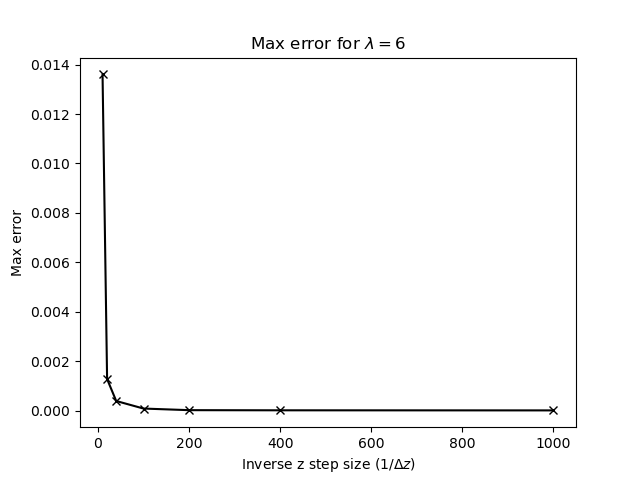

In [32]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 6$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

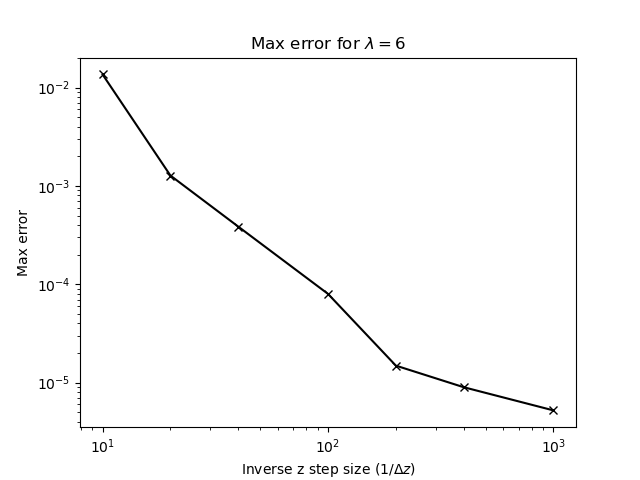

In [33]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 6$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 2. $\lambda = \frac{\Delta t}{\Delta z} = 10$

In [34]:
# Empty list to store max error values
L2_max_errors = []
L2_real_max_errors = []
# Empty list to store dt and dz's
L2_dt_vals = []
L2_dz_vals = []

#### 2.1 Parameters $\Delta z = 0.1, \Delta t = 1$

In [35]:
dZ=0.1
dt=1

In [36]:
L2P1 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.10013855831631045 and dt = 1.0
lambda = 9.98616334021179

 Tridiagonal system coefficients:
lower diag values = -0.539099720391105
diag values = 2.1318889053956367
upper diag values = -0.5827891850045315

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 292, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 22.71153273835364

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.02161545110652585 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.10079550378861862


In [37]:
L2_max_errors.append(L2P1[0])
L2_real_max_errors.append(L2P1[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.2 Parameters $\Delta z = 0.05, \Delta t = 0.5$

In [38]:
dZ=0.05
dt=0.5

In [39]:
L2P2 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.049983690646773764 and dt = 0.5
lambda = 10.003262934972428

 Tridiagonal system coefficients:
lower diag values = -1.103852142474421
diag values = 3.2564685602893464
upper diag values = -1.1476164178149255

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 585, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 39.423085664521516

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0041664547060484836 

located at 508, z value of 2.365863918620615, S value of 10.65323837410495 

2. Absolute sum of errors: 0.0421591457736431


In [40]:
L2_max_errors.append(L2P2[0])
L2_real_max_errors.append(L2P2[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.3 Parameters $\Delta z = 0.025, \Delta t = 0.25$

In [41]:
dZ = 0.025
dt = 0.25

In [42]:
L2P3 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.024991845323386882 and dt = 0.25
lambda = 10.003262934972428

 Tridiagonal system coefficients:
lower diag values = -2.2295864226190942
diag values = 5.505437120578693
upper diag values = -2.2733506979595988

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 1170, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 73.46330039828449

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0017881342212411333 

located at 1012, z value of 2.265896537327066, S value of 9.639763135622502 

2. Absolute sum of errors: 0.022753945752718645


In [43]:
L2_max_errors.append(L2P3[0])
L2_real_max_errors.append(L2P3[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.4 Parameters $\Delta z = 0.01, \Delta t = 0.1$

In [44]:
dZ=0.01
dt=0.1

In [45]:
L2P4 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.010000156986444134 and dt = 0.1
lambda = 9.999843016020302

 Tridiagonal system coefficients:
lower diag values = -5.602948737811518
diag values = 12.250646788818125
upper diag values = -5.646698051006607

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 2924, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 176.03732536538143

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.001213905383101288 

located at 2533, z value of 2.304546716722534, S value of 10.019635489709756 

2. Absolute sum of errors: 0.009742369006929805


In [46]:
L2_max_errors.append(L2P4[0])
L2_real_max_errors.append(L2P4[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.5 Parameters: $\Delta z = 0.005, \Delta t = 0.05$

In [47]:
dZ=0.005
dt=0.05

In [48]:
L2P5 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.005000078493222067 and dt = 0.05
lambda = 9.999843016020302

 Tridiagonal system coefficients:
lower diag values = -11.22777213222058
diag values = 23.49979357763625
upper diag values = -11.27152144541567

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 5848, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 347.2035396674599

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0003381531879678157 

located at 5067, z value of 2.3095467952157556, S value of 10.069859912021236 

2. Absolute sum of errors: 0.005060644903410969


In [49]:
L2_max_errors.append(L2P5[0])
L2_real_max_errors.append(L2P5[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.025$

In [50]:
dZ=0.0025
dt=0.025

In [51]:
L2P6 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.025
lambda = 9.999843016020302

 Tridiagonal system coefficients:
lower diag values = -22.477418921038705
diag values = 45.9988371552725
upper diag values = -22.521168234233794

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 11696, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 689.5995963398627

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.00028669864864405703 

located at 10131, z value of 2.302046677475925, S value of 9.994617294015042 

2. Absolute sum of errors: 0.002347870275770687


In [52]:
L2_max_errors.append(L2P6[0])
L2_real_max_errors.append(L2P6[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.7 Parameters: $\Delta z = 0.001, \Delta t = 0.01$

In [53]:
dZ=0.001
dt=0.01

In [54]:
L2P7 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.01
lambda = 9.9998430160203

 Tridiagonal system coefficients:
lower diag values = -56.22635928749307
diag values = 113.49656788818123
upper diag values = -56.27010860068816

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.67604319534911 

located at 29238, z value of 6.212608067024906, S value of 499.0009836663898 

2. Absolute sum of errors: 1716.8404948698824

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.00016853747382383766 

located at 25328, z value of 2.3025466853252468, S value of 9.99961593068766 

2. Absolute sum of errors: 0.0015813668488852712


In [55]:
L2_max_errors.append(L2P7[0])
L2_real_max_errors.append(L2P7[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### Additional steps 

In [56]:
# Empty list to store max error values
L2a_max_errors = []
L2a_real_max_errors = []
# Empty list to store dt and dz's
L2a_dt_vals = []
L2a_dz_vals = []

In [57]:
# dz = 0.075
# dt = 0.075*10

# L2a1 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a1[0])
# L2a_real_max_errors.append(L2a1[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.0375
# dt = 0.0375*10

# L2a2 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a2[0])
# L2a_real_max_errors.append(L2a2[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.0175
# dt = 0.0175*10

# L2a3 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a3[0])
# L2a_real_max_errors.append(L2a3[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.0075
# dt = 0.0075*10

# L2a4 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a4[0])
# L2a_real_max_errors.append(L2a4[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.00375
# dt = 0.00375*10

# L2a5 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a5[0])
# L2a_real_max_errors.append(L2a5[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.00175
# dt = 0.00175*10

# L2a6 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a6[0])
# L2a_real_max_errors.append(L2a6[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.00075
# dt = 0.00075*10

# L2a7 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a7[0])
# L2a_real_max_errors.append(L2a7[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.0005
# dt = 0.0005*10

# L2a8 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a8[0])
# L2a_real_max_errors.append(L2a8[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

# ###########

# dz = 0.00025
# dt = 0.00025*10

# L2a9 = PresentValue(dt=dt, dZ=dz)
# L2a_max_errors.append(L2a9[0])
# L2a_real_max_errors.append(L2a9[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dz)

#### PLOTS of Convergence for decreasing step size

In [58]:
# delta t values
dt_vals = np.array(L2_dt_vals + L2a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L2_dz_vals + L2a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L2_real_max_errors + L2a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L2_max_errors + L2a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

In [59]:
L2_dz_vals

[0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]

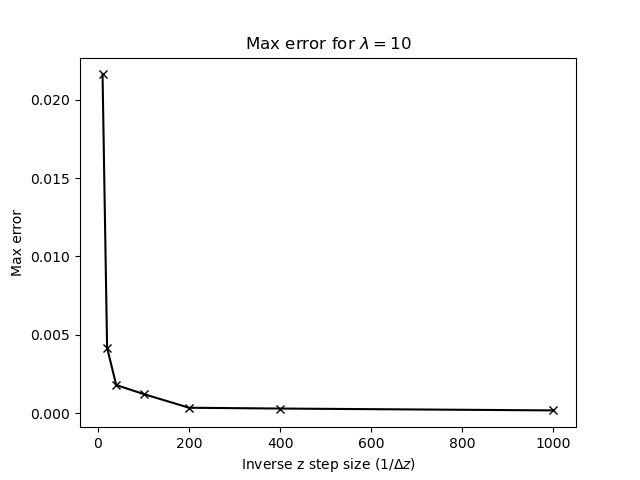

In [60]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 10$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

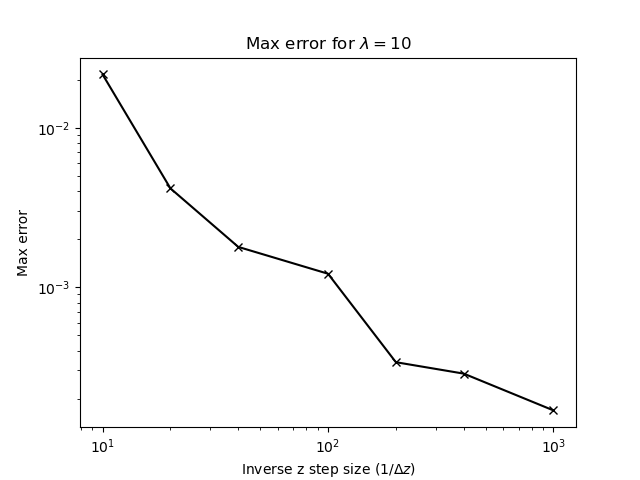

In [61]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 10$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 3. $\lambda = \frac{\Delta t}{\Delta z} = 5$

In [62]:
# Empty list to store max error values
L3_max_errors = []
L3_real_max_errors = []
# Empty list to store dt and dz's
L3_dt_vals = []
L3_dz_vals = []


#### 3.1 Parameters $\Delta z = 0.1, \Delta t = 0.5$

In [63]:
dZ=0.1
dt=0.5

In [64]:
L3P1 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.10013855831631045 and dt = 0.5
lambda = 4.993081670105895

 Tridiagonal system coefficients:
lower diag values = -0.2695498601955525
diag values = 1.5659444526978183
upper diag values = -0.29139459250226574

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 292, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 22.65608480985607

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.01535079614544066 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.09932148199548724


In [65]:
L3_max_errors.append(L3P1[0])
L3_real_max_errors.append(L3P1[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.2 Parameters $\Delta z = 0.05, \Delta t = 0.25$

In [66]:
dZ=0.05
dt=0.25

In [67]:
L3P2 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.049983690646773764 and dt = 0.25
lambda = 5.001631467486214

 Tridiagonal system coefficients:
lower diag values = -0.5519260712372105
diag values = 2.128234280144673
upper diag values = -0.5738082089074628

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 585, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 39.41787295293806

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0013572733544687243 

located at 500, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.03489673266257479


In [68]:
L3_max_errors.append(L3P2[0])
L3_real_max_errors.append(L3P2[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.3 Parameters $\Delta z = 0.025, \Delta t = 0.125$

In [69]:
dZ = 0.025
dt = 0.125

In [70]:
L3P3 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.024991845323386882 and dt = 0.125
lambda = 5.001631467486214

 Tridiagonal system coefficients:
lower diag values = -1.1147932113095471
diag values = 3.2527185602893467
upper diag values = -1.1366753489797994

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 1170, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 73.49480669299733

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0004265352039515835 

located at 1002, z value of 2.0159780840931987, S value of 7.508067312291713 

2. Absolute sum of errors: 0.021555953787041563


In [71]:
L3_max_errors.append(L3P3[0])
L3_real_max_errors.append(L3P3[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.4 Parameters $\Delta z = 0.01, \Delta t = 0.05$

In [72]:
dZ=0.01
dt=0.05

In [73]:
L3P4 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.010000156986444134 and dt = 0.05
lambda = 4.999921508010151

 Tridiagonal system coefficients:
lower diag values = -2.801474368905759
diag values = 6.625323394409063
upper diag values = -2.8233490255033034

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 2924, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 176.08520963411613

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 6.0881945730839604e-05 

located at 2533, z value of 2.304546716722534, S value of 10.019635489709756 

2. Absolute sum of errors: 0.0076051930416965955


In [74]:
L3_max_errors.append(L3P4[0])
L3_real_max_errors.append(L3P4[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.5 Parameters: $\Delta z = 0.005, \Delta t = 0.025$

In [75]:
dZ=0.005
dt=0.025

In [76]:
L3P5 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.005000078493222067 and dt = 0.025
lambda = 4.999921508010151

 Tridiagonal system coefficients:
lower diag values = -5.61388606611029
diag values = 12.249896788818125
upper diag values = -5.635760722707835

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 5848, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 347.2581010982572

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 1.619221922150027e-05 

located at 5005, z value of 1.9995419286359883, S value of 7.385672159026809 

2. Absolute sum of errors: 0.004113821090269233


In [77]:
L3_max_errors.append(L3P5[0])
L3_real_max_errors.append(L3P5[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.0125$

In [78]:
dZ=0.0025
dt=0.0125

In [79]:
L3P6 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.0125
lambda = 4.999921508010151

 Tridiagonal system coefficients:
lower diag values = -11.238709460519352
diag values = 23.49941857763625
upper diag values = -11.260584117116897

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 11696, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 689.6572764951662

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 3.609010583716099e-06 

located at 10131, z value of 2.302046677475925, S value of 9.994617294015042 

2. Absolute sum of errors: 0.0018502774292699499


In [80]:
L3_max_errors.append(L3P6[0])
L3_real_max_errors.append(L3P6[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.7 Parameters: $\Delta z = 0.001, \Delta t = 0.005$

In [81]:
dZ=0.001
dt=0.005

In [82]:
L3P7 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.005
lambda = 4.99992150801015

 Tridiagonal system coefficients:
lower diag values = -28.113179643746534
diag values = 57.248283944090616
upper diag values = -28.13505430034408

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 29240, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 1716.899798255436

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.0651523502390745e-06 

located at 25328, z value of 2.3025466853252468, S value of 9.99961593068766 

2. Absolute sum of errors: 0.0011307857865256081


In [83]:
L3_max_errors.append(L3P7[0])
L3_real_max_errors.append(L3P7[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### Additional steps 

In [84]:
# Empty list to store max error values
L3a_max_errors = []
L3a_real_max_errors = []
# Empty list to store dt and dz's
L3a_dt_vals = []
L3a_dz_vals = []

In [85]:
# dz = 0.075
# dt = 0.075*5

# L3a1 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a1[0])
# L3a_real_max_errors.append(L3a1[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.0375
# dt = 0.0375*5

# L3a2 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a2[0])
# L3a_real_max_errors.append(L3a2[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.0175
# dt = 0.0175*5

# L3a3 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a3[0])
# L3a_real_max_errors.append(L3a3[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.0075
# dt = 0.0075*5

# L3a4 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a4[0])
# L3a_real_max_errors.append(L3a4[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.00375
# dt = 0.00375*5

# L3a5 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a5[0])
# L3a_real_max_errors.append(L3a5[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.00175
# dt = 0.00175*5

# L3a6 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a6[0])
# L3a_real_max_errors.append(L3a6[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.00075
# dt = 0.00075*5

# L3a7 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a7[0])
# L3a_real_max_errors.append(L3a7[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.0005
# dt = 0.0005*5

# L3a8 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a8[0])
# L3a_real_max_errors.append(L3a8[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

# ###########

# dz = 0.00025
# dt = 0.00025*5

# L3a9 = PresentValue(dt=dt, dZ=dz)
# L3a_max_errors.append(L3a9[0])
# L3a_real_max_errors.append(L3a9[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dz)

#### PLOTS of Convergence for decreasing step size

In [86]:
# delta t values
dt_vals = np.array(L3_dt_vals + L3a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L3_dz_vals + L3a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L3_real_max_errors + L3a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L3_max_errors + L3a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

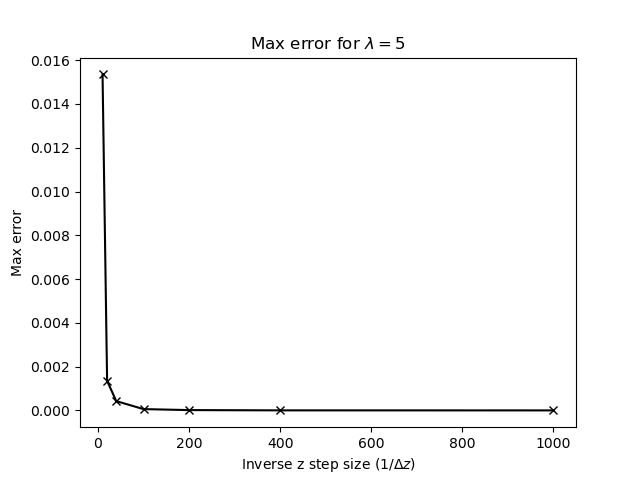

In [87]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 5$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

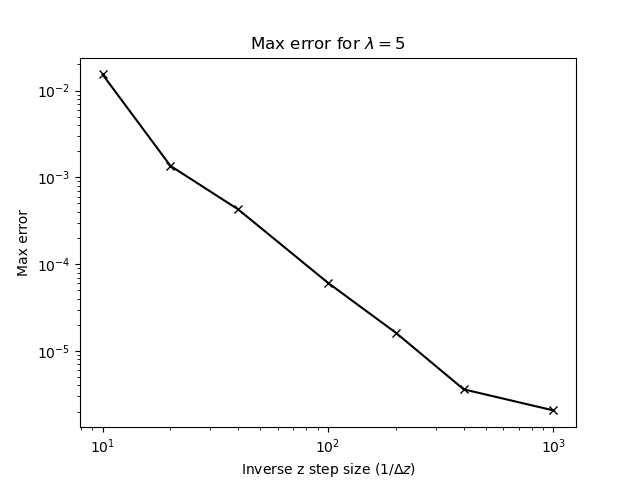

In [88]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 5$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 4. $\lambda = \frac{\Delta t}{\Delta z} = 4$

In [89]:
# Empty list to store max error values
L4_max_errors = []
L4_real_max_errors = []
# Empty list to store dt and dz's
L4_dt_vals = []
L4_dz_vals = []


#### 4.1 Parameters $\Delta z = 0.1, \Delta t = 0.4$

In [90]:
dZ=0.1
dt=0.4

In [91]:
L4P1 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.10013855831631045 and dt = 0.4
lambda = 3.9944653360847164

 Tridiagonal system coefficients:
lower diag values = -0.215639888156442
diag values = 1.4527555621582546
upper diag values = -0.2331156740018126

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 292, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 22.646621603090647

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.016017266914888584 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.10026769458103256


In [92]:
L4_max_errors.append(L4P1[0])
L4_real_max_errors.append(L4P1[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.2 Parameters $\Delta z = 0.05, \Delta t = 0.2$

In [93]:
dZ=0.05
dt=0.2

In [94]:
L4P2 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.049983690646773764 and dt = 0.2
lambda = 4.001305173988971

 Tridiagonal system coefficients:
lower diag values = -0.4415408569897684
diag values = 1.9025874241157386
upper diag values = -0.45904656712597025

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 585, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 39.41308586652014

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0014530313080092366 

located at 500, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.03605335268373404


In [95]:
L4_max_errors.append(L4P2[0])
L4_real_max_errors.append(L4P2[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.3 Parameters $\Delta z = 0.025, \Delta t = 0.1$

In [96]:
dZ = 0.025
dt = 0.1

In [97]:
L4P3 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.024991845323386882 and dt = 0.1
lambda = 4.001305173988971

 Tridiagonal system coefficients:
lower diag values = -0.8918345690476377
diag values = 2.8021748482314774
upper diag values = -0.9093402791838395

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 1170, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 73.49176540270912

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0004553049037903656 

located at 1002, z value of 2.0159780840931987, S value of 7.508067312291713 

2. Absolute sum of errors: 0.021550244711571343


In [98]:
L4_max_errors.append(L4P3[0])
L4_real_max_errors.append(L4P3[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.4 Parameters $\Delta z = 0.01, \Delta t = 0.04$

In [99]:
dZ=0.01
dt=0.04

In [100]:
L4P4 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.010000156986444134 and dt = 0.04
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -2.2411794951246073
diag values = 5.50025871552725
upper diag values = -2.2586792204026427

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 2924, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 176.08421953678967

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 6.494381155741635e-05 

located at 2535, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.007807225741885821


In [101]:
L4_max_errors.append(L4P4[0])
L4_real_max_errors.append(L4P4[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.5 Parameters: $\Delta z = 0.005, \Delta t = 0.02$

In [102]:
dZ=0.005
dt=0.02

In [103]:
L4P5 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.005000078493222067 and dt = 0.02
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -4.491108852888232
diag values = 9.999917431054499
upper diag values = -4.5086085781662675

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 5848, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 347.25752876194684

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 1.731576141231206e-05 

located at 5006, z value of 2.00454200712921, S value of 7.422693577415737 

2. Absolute sum of errors: 0.004112667252703463


In [104]:
L4_max_errors.append(L4P5[0])
L4_real_max_errors.append(L4P5[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.01$

In [105]:
dZ=0.0025
dt=0.01

In [106]:
L4P6 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.01
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -8.990967568415483
diag values = 18.999534862108998
upper diag values = -9.008467293693517

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 11696, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 689.6570705209623

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 3.3972711031005076e-06 

located at 10140, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.0019046010953888673


In [107]:
L4_max_errors.append(L4P6[0])
L4_real_max_errors.append(L4P6[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.7 Parameters: $\Delta z = 0.001, \Delta t = 0.004$

In [108]:
dZ=0.001
dt=0.004

In [109]:
L4P7 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.004
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -22.490543714997226
diag values = 45.998627155272494
upper diag values = -22.508043440275266

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 29240, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 1716.8997286379627

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 1.7305907304976387e-06 

located at 25328, z value of 2.3025466853252468, S value of 9.99961593068766 

2. Absolute sum of errors: 0.0011345187950694963


In [110]:
L4_max_errors.append(L4P7[0])
L4_real_max_errors.append(L4P7[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### Additional steps 

In [111]:
# Empty list to store max error values
L4a_max_errors = []
L4a_real_max_errors = []
# Empty list to store dt and dz's
L4a_dt_vals = []
L4a_dz_vals = []

In [112]:
# dz = 0.075
# dt = 0.075*4

# L4a1 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a1[0])
# L4a_real_max_errors.append(L4a1[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.0375
# dt = 0.0375*4

# L4a2 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a2[0])
# L4a_real_max_errors.append(L4a2[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.0175
# dt = 0.0175*4

# L4a3 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a3[0])
# L4a_real_max_errors.append(L4a3[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.0075
# dt = 0.0075*4

# L4a4 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a4[0])
# L4a_real_max_errors.append(L4a4[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.00375
# dt = 0.00375*4

# L4a5 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a5[0])
# L4a_real_max_errors.append(L4a5[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.00175
# dt = 0.00175*4

# L4a6 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a6[0])
# L4a_real_max_errors.append(L4a6[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.00075
# dt = 0.00075*4

# L4a7 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a7[0])
# L4a_real_max_errors.append(L4a7[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.0005
# dt = 0.0005*4

# L4a8 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a8[0])
# L4a_real_max_errors.append(L4a8[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

# ###########

# dz = 0.00025
# dt = 0.00025*4

# L4a9 = PresentValue(dt=dt, dZ=dz)
# L4a_max_errors.append(L4a9[0])
# L4a_real_max_errors.append(L4a9[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dz)

#### PLOTS of Convergence for decreasing step size

In [113]:
# delta t values
dt_vals = np.array(L4_dt_vals + L4a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L4_dz_vals + L4a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L4_real_max_errors + L4a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L4_max_errors + L4a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

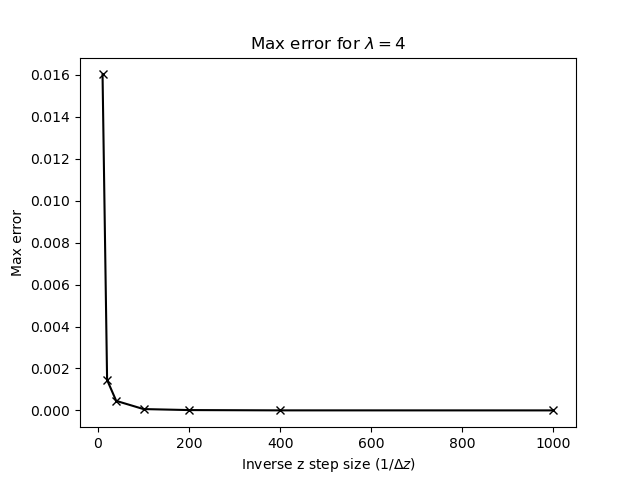

In [114]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 4$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

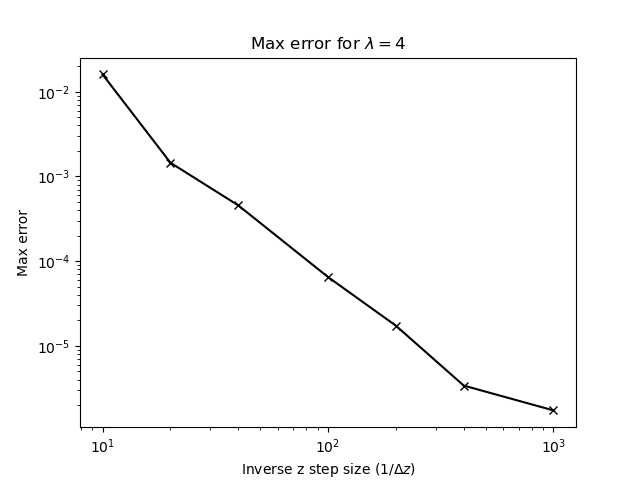

In [115]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 4$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 5. $\lambda = \frac{\Delta t}{\Delta z} = 3$

In [116]:
# Empty list to store max error values
L5_max_errors = []
L5_real_max_errors = []
# Empty list to store dt and dz's
L5_dt_vals = []
L5_dz_vals = []

#### 5.1 Parameters $\Delta z = 0.1, \Delta t = 0.3$

In [117]:
dZ=0.1
dt=0.3

In [118]:
L5P1 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.10013855831631045 and dt = 0.2857142857142857
lambda = 2.8531895257747975

 Tridiagonal system coefficients:
lower diag values = -0.1540284915403157
diag values = 1.323396830113039
upper diag values = -0.1665111957155804

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 292, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 22.638315546241873

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.016610653762498373 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.10107468449982507


In [119]:
L5_max_errors.append(L5P1[0])
L5_real_max_errors.append(L5P1[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.2 Parameters $\Delta z = 0.05, \Delta t = 0.15$

In [120]:
dZ=0.05
dt=0.15

In [121]:
L5P2 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.049983690646773764 and dt = 0.15384615384615385
lambda = 3.0779270569145933

 Tridiagonal system coefficients:
lower diag values = -0.33964681306905264
diag values = 1.694298018550568
upper diag values = -0.35311274394305403

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 585, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 39.40958992276651

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0015219397139722285 

located at 500, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.036897831935845296


In [122]:
L5_max_errors.append(L5P2[0])
L5_real_max_errors.append(L5P2[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.3 Parameters $\Delta z = 0.025, \Delta t = 0.075$

In [123]:
dZ = 0.025
dt = 0.075

In [124]:
L5P3 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.024991845323386882 and dt = 0.07407407407407407
lambda = 2.9639297585103486

 Tridiagonal system coefficients:
lower diag values = -0.6606181992945463
diag values = 2.3349443320233165
upper diag values = -0.6735853919880292

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 1170, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 73.48929069526116

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.00047836288089933565 

located at 1002, z value of 2.0159780840931987, S value of 7.508067312291713 

2. Absolute sum of errors: 0.021545664238203633


In [125]:
L5_max_errors.append(L5P3[0])
L5_real_max_errors.append(L5P3[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.4 Parameters $\Delta z = 0.01, \Delta t = 0.03$

In [126]:
dZ=0.01
dt=0.03

In [127]:
L5P4 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.010000156986444134 and dt = 0.029850746268656716
lambda = 2.9850277659762092

 Tridiagonal system coefficients:
lower diag values = -1.6725220112870203
diag values = 4.358402026512874
upper diag values = -1.6855815077631662

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 2924, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 176.0834044445478

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 6.964621874594457e-05 

located at 2535, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.00796930475257587


In [128]:
L5_max_errors.append(L5P4[0])
L5_real_max_errors.append(L5P4[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.5 Parameters: $\Delta z = 0.005, \Delta t = 0.015$

In [129]:
dZ=0.005
dt=0.015

In [130]:
L5P5 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.005000078493222067 and dt = 0.015037593984962405
lambda = 3.007471583765504

 Tridiagonal system coefficients:
lower diag values = -3.376773573600174
diag values = 7.7668552113191724
upper diag values = -3.3899312617791484

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 5848, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 347.2570482592696

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 1.8193053753584598e-05 

located at 5006, z value of 2.00454200712921, S value of 7.422693577415737 

2. Absolute sum of errors: 0.004111772292172137


In [131]:
L5_max_errors.append(L5P5[0])
L5_real_max_errors.append(L5P5[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.0075$

In [132]:
dZ=0.0025
dt=0.0075

In [133]:
L5P6 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.00749063670411985
lambda = 2.9962076452495285

 Tridiagonal system coefficients:
lower diag values = -6.734807167352421
diag values = 14.48279764951985
upper diag values = -6.747915575800388

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 11696, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 689.656871582882

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 3.6905044191737346e-06 

located at 10139, z value of 2.3220469914488113, S value of 10.196525157840666 

2. Absolute sum of errors: 0.0019476678614022218


In [134]:
L5_max_errors.append(L5P6[0])
L5_real_max_errors.append(L5P6[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.7 Parameters: $\Delta z = 0.001, \Delta t = 0.003$

In [135]:
dZ=0.001
dt=0.003

In [136]:
L5P7 = PresentValue(dt=dt, dZ=dZ)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.0029985007496251873
lambda = 2.9984536779671065

 Tridiagonal system coefficients:
lower diag values = -16.859478047224307
diag values = 34.73210431429722
upper diag values = -16.872596282065416

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 29240, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 1716.899637807127

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 1.7725204062291056e-06 

located at 25334, z value of 2.3085467795171155, S value of 10.05979492743618 

2. Absolute sum of errors: 0.001138531159613195


In [137]:
L5_max_errors.append(L5P7[0])
L5_real_max_errors.append(L5P7[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### Additional dz values

In [138]:
# Empty list to store max error values
L5a_max_errors = []
L5a_real_max_errors = []
# Empty list to store dt and dz's
L5a_dt_vals = []
L5a_dz_vals = []


In [139]:
# dz = 0.075
# dt = 0.075*3

# L5a1 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a1[0])
# L5a_real_max_errors.append(L5a1[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.0375
# dt = 0.0375*3

# L5a2 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a2[0])
# L5a_real_max_errors.append(L5a2[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.0175
# dt = 0.0175*3

# L5a3 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a3[0])
# L5a_real_max_errors.append(L5a3[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.0075
# dt = 0.0075*3

# L5a4 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a4[0])
# L5a_real_max_errors.append(L5a4[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.00375
# dt = 0.00375*3

# L5a5 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a5[0])
# L5a_real_max_errors.append(L5a5[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.00175
# dt = 0.00175*3

# L5a6 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a6[0])
# L5a_real_max_errors.append(L5a6[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.00075
# dt = 0.00075*3

# L5a7 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a7[0])
# L5a_real_max_errors.append(L5a7[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.0005
# dt = 0.0005*3

# L5a8 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a8[0])
# L5a_real_max_errors.append(L5a8[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

# ###########

# dz = 0.00025
# dt = 0.00025*3

# L5a9 = PresentValue(dt=dt, dZ=dz)
# L5a_max_errors.append(L5a9[0])
# L5a_real_max_errors.append(L5a9[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dz)

#### PLOTS of Convergence for decreasing step size

In [150]:
# delta t values
dt_vals = np.array(L5_dt_vals + L5a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L5_dz_vals + L5a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L5_real_max_errors + L5a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L5_max_errors + L5a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

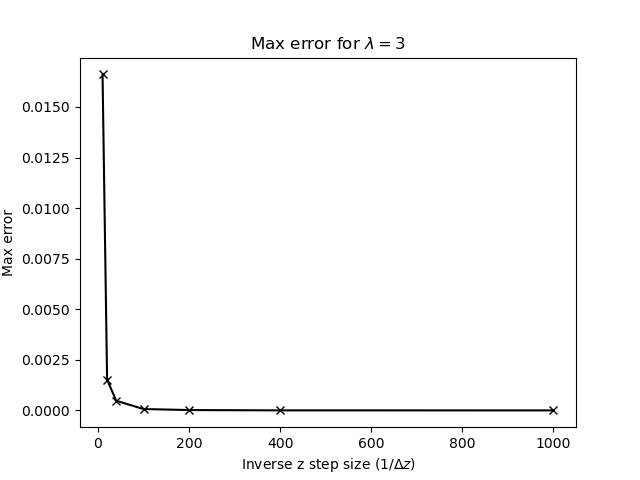

In [151]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 3$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

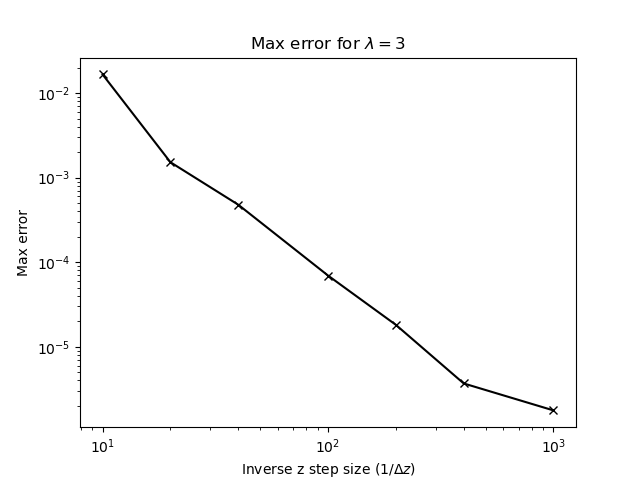

In [152]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 3$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

# NEXT CELL

### STORING DATA

In [143]:
# write a pandas dataframe with all the values so that they do not need to be recalculated
import pandas as pd

ErrorVals1 = pd.DataFrame({'Real Errors': L1_real_max_errors + L1a_real_max_errors,
                           'dt': L1_dt_vals + L1a_dt_vals, 
                           'dz': L1_dz_vals + L1a_dz_vals,
                           'lambda': np.divide(np.array(L1_dt_vals + L1a_dt_vals), 
                                               np.array(L1_dz_vals + L1a_dz_vals)),
                           'Entire Errors': L1_max_errors + L1a_max_errors,
                         })

print(ErrorVals1)

# write to csv file
ErrorVals1.to_csv('CN l6 data.csv', index=False)

### --------------------------------------------

ErrorVals2 = pd.DataFrame({'Real Errors': L2_real_max_errors + L2a_real_max_errors,
                           'dt': L2_dt_vals + L2a_dt_vals, 
                           'dz': L2_dz_vals + L2a_dz_vals,
                           'lambda': np.divide(np.array(L2_dt_vals + L2a_dt_vals), 
                                               np.array(L2_dz_vals + L2a_dz_vals)),
                           'Entire Errors': L2_max_errors + L2a_max_errors,
                         })

print(ErrorVals2)

# write to csv file
ErrorVals2.to_csv('CN l10 data.csv', index=False)

### --------------------------------------------

ErrorVals3 = pd.DataFrame({'Real Errors': L3_real_max_errors + L3a_real_max_errors,
                           'dt': L3_dt_vals + L3a_dt_vals, 
                           'dz': L3_dz_vals + L3a_dz_vals,
                           'lambda': np.divide(np.array(L3_dt_vals + L3a_dt_vals), 
                                               np.array(L3_dz_vals + L3a_dz_vals)),
                           'Entire Errors': L3_max_errors + L3a_max_errors,
                         })

print(ErrorVals3)

# write to csv file
ErrorVals3.to_csv('CN l5 data.csv', index=False)

### --------------------------------------------

ErrorVals4 = pd.DataFrame({'Real Errors': L4_real_max_errors + L4a_real_max_errors,
                           'dt': L4_dt_vals + L4a_dt_vals, 
                           'dz': L4_dz_vals + L4a_dz_vals,
                           'lambda': np.divide(np.array(L4_dt_vals + L4a_dt_vals), 
                                               np.array(L4_dz_vals + L4a_dz_vals)),
                           'Entire Errors': L4_max_errors + L4a_max_errors,
                         })

print(ErrorVals4)

# write to csv file
ErrorVals4.to_csv('CN l4 data.csv', index=False)

### --------------------------------------------

ErrorVals5 = pd.DataFrame({'Real Errors': L5_real_max_errors + L5a_real_max_errors,
                           'dt': L5_dt_vals + L5a_dt_vals, 
                           'dz': L5_dz_vals + L5a_dz_vals,
                           'lambda': np.divide(np.array(L5_dt_vals + L5a_dt_vals), 
                                               np.array(L5_dz_vals + L5a_dz_vals)),
                           'Entire Errors': L5_max_errors + L5a_max_errors,
                         })

print(ErrorVals5)

# write to csv file
ErrorVals5.to_csv('CN l3 data.csv', index=False)

   Real Errors     dt      dz  lambda  Entire Errors
0     0.013606  0.600  0.1000     6.0       9.607894
1     0.001275  0.300  0.0500     6.0       9.607894
2     0.000386  0.150  0.0250     6.0       9.607894
3     0.000080  0.060  0.0100     6.0       9.607894
4     0.000015  0.030  0.0050     6.0       9.607894
5     0.000009  0.015  0.0025     6.0       9.607894
6     0.000005  0.006  0.0010     6.0       9.607894
   Real Errors     dt      dz  lambda  Entire Errors
0     0.021615  1.000  0.1000    10.0       9.607894
1     0.004166  0.500  0.0500    10.0       9.607894
2     0.001788  0.250  0.0250    10.0       9.607894
3     0.001214  0.100  0.0100    10.0       9.607894
4     0.000338  0.050  0.0050    10.0       9.607894
5     0.000287  0.025  0.0025    10.0       9.607894
6     0.000169  0.010  0.0010    10.0       9.676043
   Real Errors      dt      dz  lambda  Entire Errors
0     0.015351  0.5000  0.1000     5.0       9.607894
1     0.001357  0.2500  0.0500     5.0      

# All on one PLOT

In [144]:
# delta z values
dz_vals_l6 = np.array(L1_dz_vals + L1a_dz_vals)
sorted_indices = np.argsort(dz_vals_l6)
dz_vals_l6 = np.array([dz_vals_l6[i] for i in sorted_indices])
inv_dz_vals_l6 = np.divide(np.ones(len(dz_vals_l6)), dz_vals_l6)

# max errors in realistic range
real_max_errors_l6 = np.array(L1_real_max_errors + L1a_real_max_errors)
real_max_errors_l6 = np.array([real_max_errors_l6[i] for i in sorted_indices])

In [145]:
# delta z values
dz_vals_l10 = np.array(L2_dz_vals + L2a_dz_vals)
sorted_indices = np.argsort(dz_vals_l10)
dz_vals_l10 = np.array([dz_vals_l10[i] for i in sorted_indices])
inv_dz_vals_l10 = np.divide(np.ones(len(dz_vals_l10)), dz_vals_l10)

# max errors in realistic range
real_max_errors_l10 = np.array(L2_real_max_errors + L2a_real_max_errors)
real_max_errors_l10 = np.array([real_max_errors_l10[i] for i in sorted_indices])

In [146]:
# delta z values
dz_vals_l5 = np.array(L3_dz_vals + L3a_dz_vals)
sorted_indices = np.argsort(dz_vals_l5)
dz_vals_l5 = np.array([dz_vals_l5[i] for i in sorted_indices])
inv_dz_vals_l5 = np.divide(np.ones(len(dz_vals_l5)), dz_vals_l5)

# max errors in realistic range
real_max_errors_l5 = np.array(L3_real_max_errors + L3a_real_max_errors)
real_max_errors_l5 = np.array([real_max_errors_l5[i] for i in sorted_indices])

In [147]:
# delta z values
dz_vals_l4 = np.array(L4_dz_vals + L4a_dz_vals)
sorted_indices = np.argsort(dz_vals_l4)
dz_vals_l4 = np.array([dz_vals_l4[i] for i in sorted_indices])
inv_dz_vals_l4 = np.divide(np.ones(len(dz_vals_l4)), dz_vals_l4)

# max errors in realistic range
real_max_errors_l4 = np.array(L4_real_max_errors + L4a_real_max_errors)
real_max_errors_l4 = np.array([real_max_errors_l4[i] for i in sorted_indices])

In [148]:
# delta z values
dz_vals_l3 = np.array(L5_dz_vals + L5a_dz_vals)
sorted_indices = np.argsort(dz_vals_l3)
dz_vals_l3 = np.array([dz_vals_l3[i] for i in sorted_indices])
inv_dz_vals_l3 = np.divide(np.ones(len(dz_vals_l3)), dz_vals_l3)

# max errors in realistic range
real_max_errors_l3 = np.array(L5_real_max_errors + L5a_real_max_errors)
real_max_errors_l3 = np.array([real_max_errors_l3[i] for i in sorted_indices])

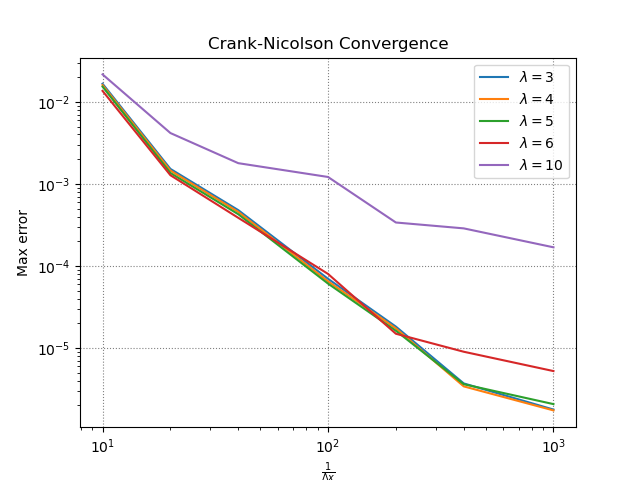

In [149]:
plt.figure()
plt.title('Crank-Nicolson Convergence')
plt.xlabel('$\\frac{1}{\\Delta x}$')
plt.ylabel('Max error')
plt.loglog(inv_dz_vals_l3, real_max_errors_l3, label='$\\lambda = 3$')
plt.loglog(inv_dz_vals_l4, real_max_errors_l4, label='$\\lambda = 4$')
plt.loglog(inv_dz_vals_l5, real_max_errors_l5, label='$\\lambda = 5$')
plt.loglog(inv_dz_vals_l6, real_max_errors_l6, label='$\\lambda = 6$')
plt.loglog(inv_dz_vals_l10, real_max_errors_l10, label='$\\lambda = 10$')
plt.legend()
plt.grid(True, linestyle='dotted', color='grey')
plt.show()
